In [1]:
import datetime
import numpy as np
import pandas
import json
from pathlib import Path
import glob
import pandas as pd 
from matplotlib.dates import HourLocator, DateFormatter, DayLocator
import matplotlib.pyplot as plt
 

In [2]:
project_directory = Path.cwd().parent

In [3]:
def merge_dict(old_dict, new_dict):    
    for station, dock_timedict in new_dict.items():
        for dock_time, numdict in dock_timedict.items():
        
            if not old_dict.get(station):
                old_dict[station] = {dock_time:numdict}
        
            elif dock_time not in old_dict[station]:
                old_dict[station] = {**old_dict[station], dock_time:numdict}  

    return old_dict

In [7]:
reload_data = False

if reload_data:
    
    rawdatapath = project_directory.joinpath('rawdata') 
    data_files = glob.glob(str(rawdatapath)+'/*')
    data_files[-5:]

    data_dict = {}
    for file in data_files:
        print(f"loading file: {file}")
        with open(file, "r") as read_file:
            file_data = json.load(read_file) 
            data_dict = merge_dict(data_dict, file_data) 

    dict_of_df = {k: pd.DataFrame(v) for k,v in data_dict.items()}
    df = pd.concat(dict_of_df, axis=1).transpose() 

    df.reset_index(level=[0,1], inplace=True)
    df['level_1'] = df.level_1.apply(lambda x: datetime.datetime.fromtimestamp(int(x)) )

    df.rename(columns={'level_0':'station', 'level_1':'timestamp'}, inplace=True)

    bool_active = df['timestamp'] > np.datetime64('2020-01-01 12:00:00')
    df = df[bool_active]

    df = df.reset_index(drop=True)
    
    filename = rawdatapath / f'merged_data_{datetime.datetime.now().date()}.ftr'
    df.to_feather(filename)
else:
    cleandatapath = project_directory.joinpath('cleandata') 
    filename = cleandatapath / f'merged_data_2020-08-23.ftr'
    df = pd.read_feather(filename, columns=None, use_threads=True);

df.head()

,station,timestamp,num_bikes_available,num_ebikes_available
0,79,2020-08-18 19:41:13,13,0
1,79,2020-08-21 20:58:26,12,0
2,79,2020-08-21 21:22:50,13,0
3,79,2020-08-21 21:23:36,12,0
4,79,2020-08-21 21:24:25,11,0


81st and 2nd
78th and 2nd
68th and 1st


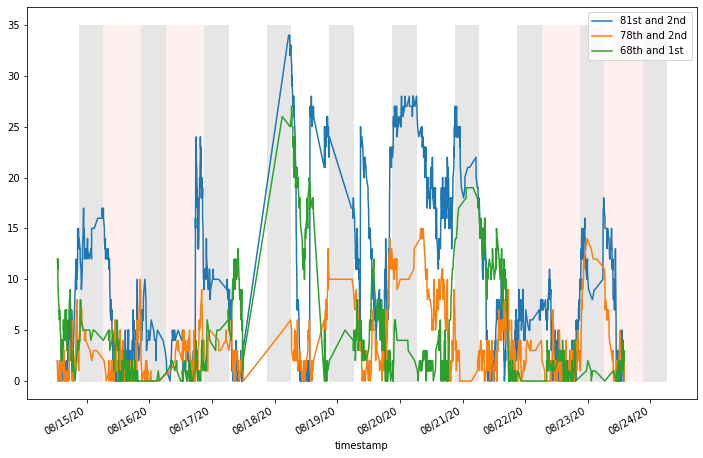

In [8]:
station_list = ['3671','3370','3131'] 
station_lookup = {
  '3671':'81st and 2nd',
    '3370': '78th and 2nd',
    '3131': '68th and 1st' 
}
t_array = np.arange( datetime.datetime(2020,8,14), 
              datetime.datetime(2020,8,24), 
              datetime.timedelta(days=1)) 

t_start = datetime.timedelta(hours=21)
t_end = datetime.timedelta(hours=30)
t_24 = datetime.timedelta(hours=24)

    
fig, ax = plt.subplots(1,1, figsize=(12,8))

for station_nr, station_street in station_lookup.items():
    bool_station = df['station'] == station_nr
    df[bool_station].plot(ax=ax, x='timestamp', y='num_bikes_available', legend=False, label=station_street)
    print(station_street)

for t in t_array:
    t = t.astype(datetime.datetime)
    
    if t.weekday() in [5,6]: 
        ax.fill_between([ t,
                     t+t_24],
                    np.array([1,1])*35,
                    color = np.array([255,240,240])/255,
                       zorder = -1) 
    
    ax.fill_between([ t+t_start,
                     t+t_end],
                    np.array([1,1])*35,
                    color = np.ones((3))*0.9) 
    
ax.xaxis.set_major_locator(DayLocator(interval=1)) # tick every two hours
ax.xaxis.set_major_formatter(DateFormatter('%D')) 
ax.legend()